In [1]:
# ------------------  set up logging ----------------------
import logging
from auditory_cortex.utils import set_up_logging
set_up_logging('info')

from auditory_cortex.plotters import tikzplots
import matplotlib.pyplot as plt
%matplotlib inline


INFO:Created a temporary directory at /tmp/tmp_iktoq0r
INFO:Writing /tmp/tmp_iktoq0r/_remote_module_non_scriptable.py

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


/bin/sh: line 1: sox: command not found


In [2]:
save_tikz = False
threshold = 0.5
lag=200

#### timit

INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
INFO:Getting dist for layer_id=2
INFO:Number of sig. neurons = 411
INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
INFO:Getting dist for layer_id=2
INFO:Number of sig. neurons = 411
INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
INFO:Getting dist for layer_id=2
INFO:Number of sig. neurons = 411
INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
INFO:Getting dist for layer_id=2
INFO:Number of sig. neurons = 411
INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
INFO:Getting dist for layer_id=2
INFO:Number of sig. neurons = 411
INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std d

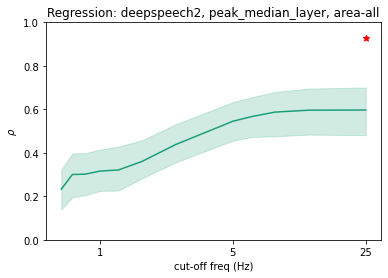

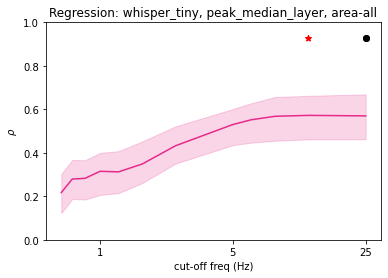

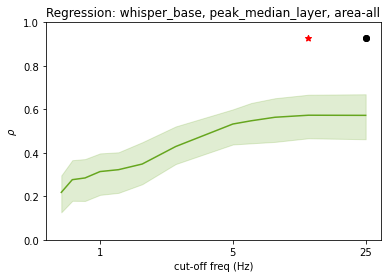

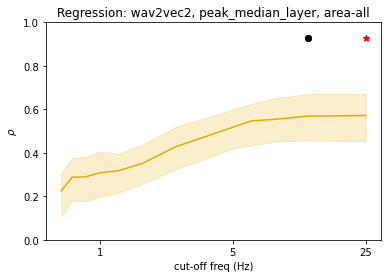

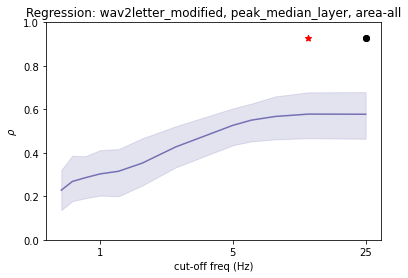

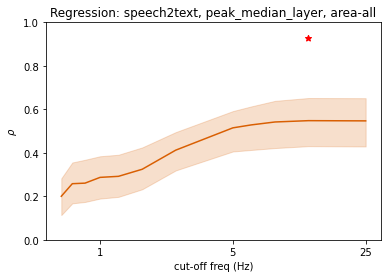

In [4]:
model_names = [
	'deepspeech2',
	'whisper_tiny',
	'whisper_base',
	'wav2vec2',
	'wav2letter_modified',
	'speech2text',
]
layer_ids = [
	2,
	2,
	2,
	4, 
	3,
	6, 
]
norm_bin_width = 20
identifier = f'ucsf_timit_trf_lags{lag}_ahmed_25_LPF_20'
tikz_indicator = f'trf{lag}'
tikzplots.plot_best_layer_across_all_bin_widths(
	model_names=model_names,
	layer_ids=layer_ids,
    tikz_indicator=tikz_indicator,
    threshold=threshold,
	identifier=identifier,
	save_tikz=save_tikz,
	norm_bin_width=norm_bin_width,
)


### simulation..

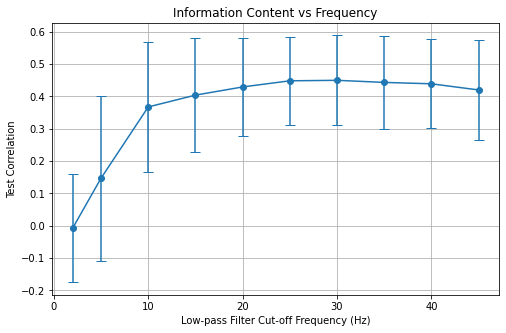

In [5]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

# Parameters
fs = 100  # sampling frequency in Hz
duration = 2.0  # seconds
n_samples = int(fs * duration)
n_repeats = 10

# Cut-off frequencies to test
cutoff_freqs = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45]

# Store results
correlations = np.zeros((n_repeats, len(cutoff_freqs)))

# Create frequency components
def band_limited_noise(min_freq, max_freq, samples, fs):
    freqs = np.fft.rfftfreq(samples, d=1/fs)
    f_signal = np.zeros(len(freqs), dtype=complex)
    idx = np.logical_and(freqs >= min_freq, freqs <= max_freq)
    f_signal[idx] = np.random.randn(np.sum(idx)) + 1j * np.random.randn(np.sum(idx))
    time_signal = np.fft.irfft(f_signal)
    return time_signal

# Low pass filter
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = signal.butter(order, norm_cutoff, btype='low', analog=False)
    return signal.filtfilt(b, a, data, axis=0)

# Repeat experiment
for repeat in range(n_repeats):
    np.random.seed(repeat)  # for reproducibility

    # Generate x (10D)
    x = np.zeros((n_samples, 10))
    for i in range(10):
        x[:, i] = band_limited_noise(0, 50, n_samples, fs)  # noise across full band

    # Generate y
    y = band_limited_noise(0, 50, n_samples, fs)

    # Inject shared information (10–20 Hz)
    shared_signal = band_limited_noise(1, 5, n_samples, fs)
    shared_signal = shared_signal / np.std(shared_signal)  # normalize
    shared_signal = shared_signal * 1.5  # 🔥 boost its power

    # For x: strong signals outside shared band (e.g., 30–40 Hz)
    x_private_signal = band_limited_noise(49, 50, n_samples, fs)
    x_private_signal = x_private_signal / np.std(x_private_signal)
    x_private_signal = x_private_signal * 2
    # For y: strong signals outside shared band (e.g., 2–5 Hz)
    y_private_signal = band_limited_noise(1, 50, n_samples, fs)
    y_private_signal = y_private_signal / np.std(y_private_signal)
    y_private_signal = y_private_signal * 2


    # x will have shared signal + private signal + small noise
    x = np.zeros((n_samples, 10))
    for i in range(10):
        x[:, i] = shared_signal + x_private_signal + 0.2 * np.random.randn(n_samples)

    # y will have shared signal + private signal + small noise
    y = shared_signal + y_private_signal + 0.2 * np.random.randn(n_samples)


    # Split into train (first 1.5s) and test (last 0.5s)
    train_samples = int(1.5 * fs)
    x_train, x_test = x[:train_samples], x[train_samples:]
    y_train, y_test = y[:train_samples], y[train_samples:]

    # Loop over cutoffs
    for idx, cutoff in enumerate(cutoff_freqs):
        # Filter x
        x_train_filt = butter_lowpass_filter(x_train, cutoff, fs)
        x_test_filt = butter_lowpass_filter(x_test, cutoff, fs)

        # Standardize
        scaler = StandardScaler()
        x_train_filt = scaler.fit_transform(x_train_filt)
        x_test_filt = scaler.transform(x_test_filt)

        # Fit linear model
        model = Ridge(alpha=1e-3)
        model.fit(x_train_filt, y_train)
        y_pred = model.predict(x_test_filt)

        # Compute correlation
        corr, _ = pearsonr(y_pred, y_test)
        correlations[repeat, idx] = corr

# Plot results
mean_corr = correlations.mean(axis=0)
std_corr = correlations.std(axis=0)

plt.figure(figsize=(8, 5))
plt.errorbar(cutoff_freqs, mean_corr, yerr=std_corr, fmt='-o', capsize=5)
plt.xlabel('Low-pass Filter Cut-off Frequency (Hz)')
plt.ylabel('Test Correlation')
plt.title('Information Content vs Frequency')
plt.grid(True)
plt.show()
